### Notebook for Figure 2 and related data

### Influence of M2 injection time on quantification
Compare the quantification precision and accuracy of pooled single-cell level sample measurements using different M2 injection times and AGC targets (in triplicates).

In [47]:
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples
import seaborn as sns
import sceptre as spt

In [48]:
figwd = 7.2 # standard figure width
cellsize= 40 # size to plot cells
wspace = 1 # space between scanpy plots to make room for legends
hspace = 0.5 # space between scanpy plots to make room for legends

In [49]:
# create result folder
res_dir = '../results/CV_analysis/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [50]:
# load PD tables
prot = pd.read_table('../data/cv/cv_Proteins.txt')
psms = pd.read_table('../data/cv/cv_PSMs.txt')
msms = pd.read_table('../data/cv/cv_MSMSSpectrumInfo.txt')
files = pd.read_table('../data/cv/cv_InputFiles.txt')

In [51]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
prot['contaminant'] = prot['Accession'].isin(contaminants)
prot = prot[prot['contaminant']==False]

In [52]:
# map condition
psms['Method'] = psms['Spectrum File'].apply(lambda x: x.split('_')[-2])
psms['Replicate'] = psms['Spectrum File'].apply(lambda x: x.split('_')[-1].split('.')[0])
msms['Method'] = msms['Spectrum File'].apply(lambda x: x.split('_')[-2])
msms['Replicate'] = msms['Spectrum File'].apply(lambda x: x.split('_')[-1].split('.')[0])

cols = list(map(lambda x: x.split(' '), prot.columns[prot.columns.str.contains('Abundance')]))
file_id = [x[-2] for x in cols]
channel = [x[-1] for x in cols]
inj = {'F1': '150ms', 'F2': '150ms', 'F3': '150ms', 'F4':'300ms', 'F5':'300ms', 'F6':'300ms',
       'F7':'500ms', 'F8':'500ms', 'F9':'500ms', 'F10':'1000ms', 'F11':'1000ms', 'F12':'1000ms'}
injection_time = [inj[x] for x in file_id]

# map cells
cells = {'126': 'booster',
        '127N': 'BLAST1',
        '127C': 'empty',
        '128N': 'BLAST2',
        '128C': 'BLAST3',
        '129N': 'BLAST4',
        '129C': 'PROG1',
        '130N': 'PROG2',
        '130C': 'PROG3',
        '131N': 'PROG4',
        '131C': 'PROG5',
        '132N': 'LSC1',
        '132C': 'LSC2',
        '133N': 'LSC3',
        '133C': 'LSC4',
        '134N': 'LSC5'}

cell = [cells[x] for x in channel]
celltype = [x[:-1] for x in cell]

In [53]:
# load into scanpy
quant = prot.set_index('Accession').copy()
quant = quant[quant.columns[quant.columns.str.contains('Abundance')]]
quant.columns = pd.MultiIndex.from_tuples(zip(file_id, channel, injection_time, cell, celltype), names=['File ID', 'Channel', 'Method', 'Cell Pool', 'Celltype'])
quant = quant.loc[:, (quant.columns.get_level_values(1) != '126') & (quant.columns.get_level_values(1) != '127C')] # remove empty channels
quant[quant < 1.1] = pd.NA # set S/N values below 1.1 to NA
quant = quant.dropna(how='all').fillna(0) # remove all NA proteins and fill remaining NA with 0
# save to file and load it in scanpy
quant.to_csv('../results/tmp/scanpy_data.txt', sep='\t', header=False, index=True)
adata = sc.read_text('../results/tmp/scanpy_data.txt', delimiter='\t', first_column_names=False).T
adata.obs = quant.columns.to_frame(index=False)

In [54]:
# store raw s/n values before normalization
raw_sn = pd.DataFrame(adata.X.copy()).replace(0, pd.NA)
raw_sn['Method'] = adata.obs['Method']
raw_sn['Cell Pool'] = adata.obs['Cell Pool']

In [55]:
# apply file normalization to the 3 files of each of the method.
# file normalization equalizes the median value of each protein across files.
for j in adata.obs['Method'].unique():
    adata_slice = adata[adata.obs['Method']==j].copy()
    spt.normalize(adata_slice, method='file', drop_na=False)
    adata.X[adata.obs['Method']==j] = adata_slice.X

53 values below 1.1 were set to 0
24 values below 1.1 were set to 0
21 values below 1.1 were set to 0
0 values below 1.1 were set to 0


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [56]:
# calculate cv of each protein in each method
df = pd.DataFrame(adata.X).replace(0, pd.NA)
df['Method'] = adata.obs['Method']
df['Cell Pool'] = adata.obs['Cell Pool']
num = df.groupby(['Method', 'Cell Pool']).count()
means = raw_sn.groupby(['Method', 'Cell Pool']).apply(np.mean)
stds = df.groupby(['Method', 'Cell Pool']).apply(np.std)
CVs = stds/means

In [57]:
# calculate parameters of each method
agc_reached = {}
for i in psms['Method'].unique():
    t = float(i[:-2])
    agc_reached[i] = round(np.mean(psms.loc[psms['Method']==i, 'Ion Inject Time in ms'] < t), 3)

params = pd.DataFrame.from_dict(agc_reached, orient='index', columns=['Fraction AGC target reached'])
params = params.merge((psms.groupby(['Method', 'Replicate']).size()/msms.groupby(['Method', 'Replicate']).size()).reset_index().groupby('Method').mean().round(2),
                      left_index=True, right_index=True)
params.columns = ['Fraction AGC target reached', 'PSM rate']
params = params.merge(msms.groupby(['Method', 'Replicate']).size().reset_index().groupby('Method').mean().astype(int),
                      left_index=True, right_index=True)
params.columns = ['Fraction of PSM with AGC target reached', 'PSM rate', 'MSMS Spectra']

# number of proteins
IDs = {}
for i in adata.obs['Method'].unique():
    adata_slice = adata[adata.obs['Method']==i].copy()
    sc.pp.filter_genes(adata_slice, min_cells=1)
    IDs[i] = adata_slice.shape[1]

params = params.merge(pd.DataFrame.from_dict(IDs, orient='index', columns=['Number of proteins']), left_index=True, right_index=True)

# Number of proteins with mean CV below 0.2
CV_filtered = {}
for i in adata.obs['Method'].unique():
    CV_filtered[i] = (CVs[num == 3].loc[i].dropna(axis=1).mean() <= 0.2).sum()

params = params.merge(pd.DataFrame.from_dict(CV_filtered, orient='index', columns=['Number of proteins with mean CV below 0.2']),
                      left_index=True, right_index=True)

params.loc[['1000ms', '500ms', '300ms', '150ms'], ['MSMS Spectra', 'PSM rate', 'Fraction of PSM with AGC target reached',
                                                   'Number of proteins', 'Number of proteins with mean CV below 0.2']]

filtered out 274 genes that are detected in less than 1 cells
filtered out 266 genes that are detected in less than 1 cells
filtered out 702 genes that are detected in less than 1 cells
filtered out 1120 genes that are detected in less than 1 cells


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,MSMS Spectra,PSM rate,Fraction of PSM with AGC target reached,Number of proteins,Number of proteins with mean CV below 0.2
1000ms,8175,0.24,0.142,692,341
500ms,14556,0.24,0.012,1110,459
300ms,22418,0.22,0.013,1546,462
150ms,33002,0.14,0.005,1538,212


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1496 genes that are detected in less than 42 cells
computing PCA
    with n_comps=20


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished (0:00:00)


... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1246 genes that are detected in less than 42 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1309 genes that are detected in less than 42 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Q58F21']
    finished (0:00:00)
filtered out 1451 genes that are detected in less than 42 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


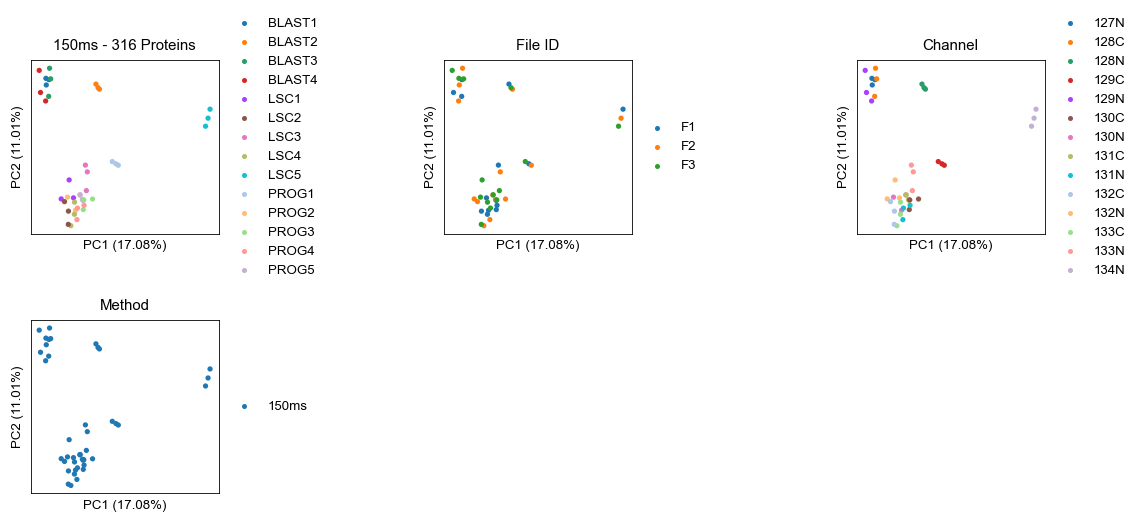

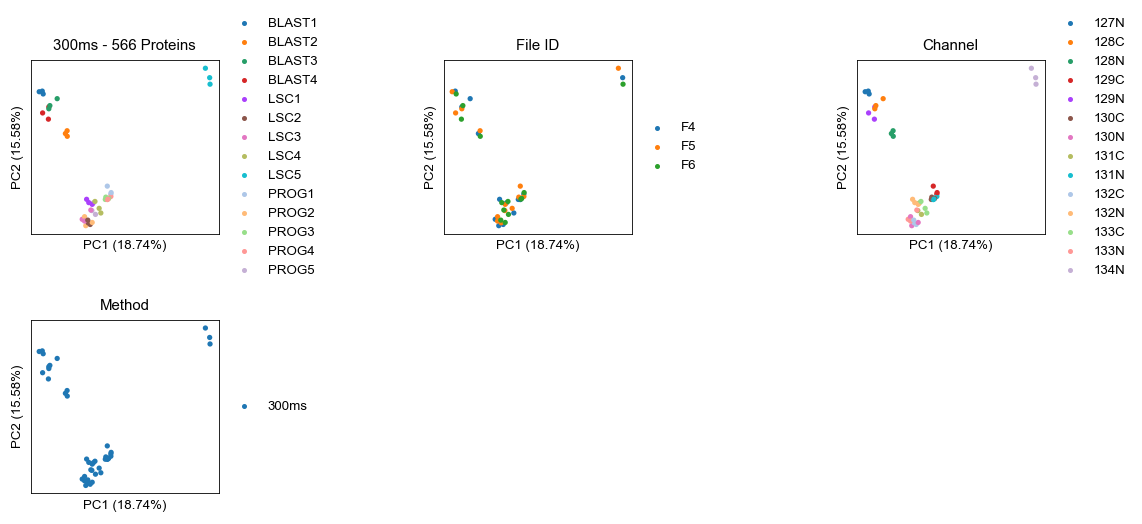

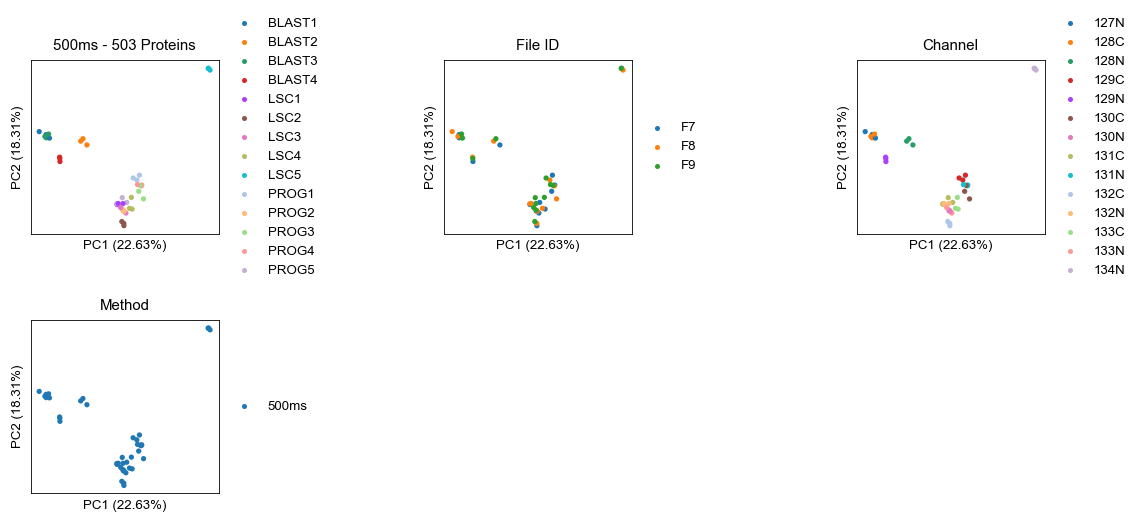

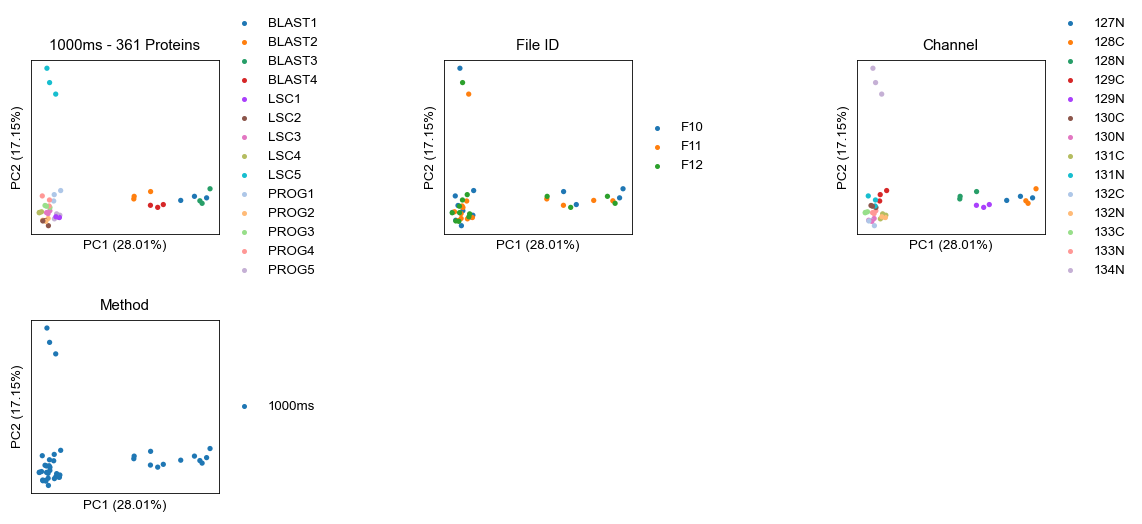

In [58]:
# plot pca of each cell pool
# set figsize for scanpy 3 columns
plt.rcParams['figure.figsize'] = (figwd*0.25, 2.2) # 4 cols 6 rows

silhouettes = {'specific':{}, 'overlap':{}}
num_prots = {}
for j in adata.obs['Method'].unique():
    adata_slice = adata[adata.obs['Method']==j].copy()
    sc.pp.normalize_total(adata_slice, exclude_highly_expressed=True) # median shift of total intensity across cells
    sc.pp.log1p(adata_slice, base=2) # log2(x+1) transformation
    sc.pp.filter_genes(adata_slice, min_cells=adata_slice.shape[0])
    sc.pp.pca(adata_slice, n_comps=20)
    axs = sc.pl.pca(adata_slice, color=['Cell Pool', 'File ID', 'Channel', 'Method',], size=cellsize, wspace=wspace, hspace=hspace,
                    ncols=3, show=False, title='{} - {} Proteins'.format(j, adata_slice.shape[1]), annotate_var_explained=True)
    # blast vs lsc silhuette score
    adata_slice = adata_slice[adata_slice.obs['Celltype'].isin(['BLAST', 'LSC'])]
    silhouettes['specific'][j] = silhouette_samples(adata_slice.obsm['X_pca'], adata_slice.obs['Celltype'])
    num_prots[j] = adata_slice.shape[1]
    plt.savefig(res_dir + 'pca_separate_{}.pdf'.format(j), transparent=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1606 genes that are detected in less than 168 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1606 genes that are detected in less than 168 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1606 genes that are detected in less than 168 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Q58F21']
    finished (0:00:00)
filtered out 1606 genes that are detected in less than 168 cells
computing PCA
    with n_comps=20
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'File ID' as categorical
... storing 'Channel' as categorical
... storing 'Method' as categorical
... storing 'Cell Pool' as categorical
... storing 'Celltype' as categorical


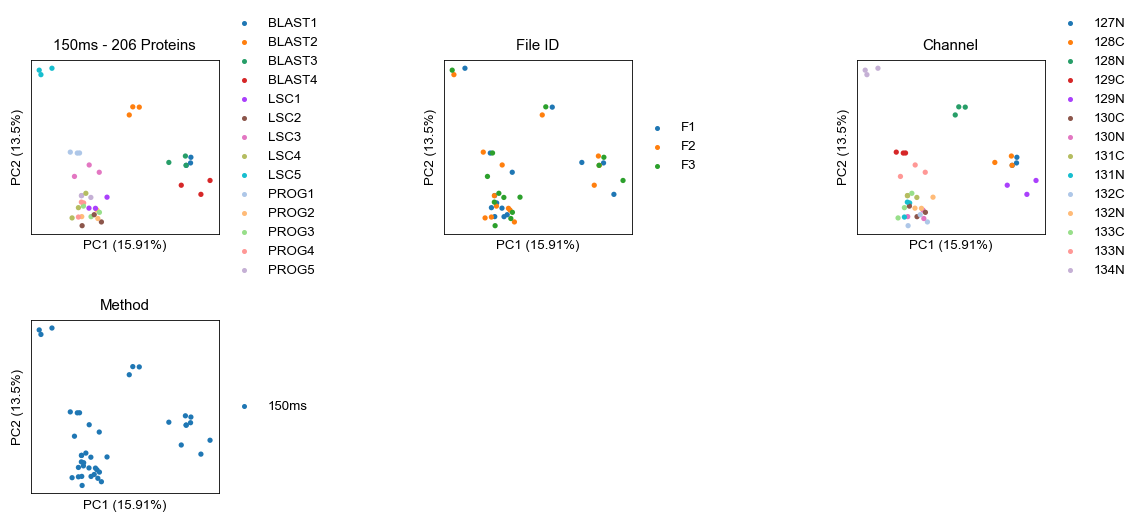

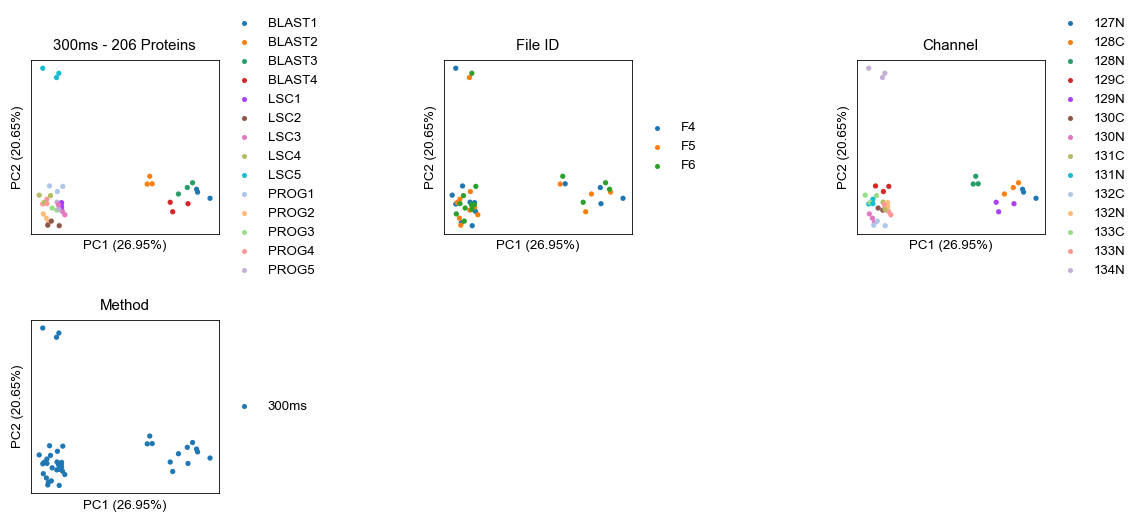

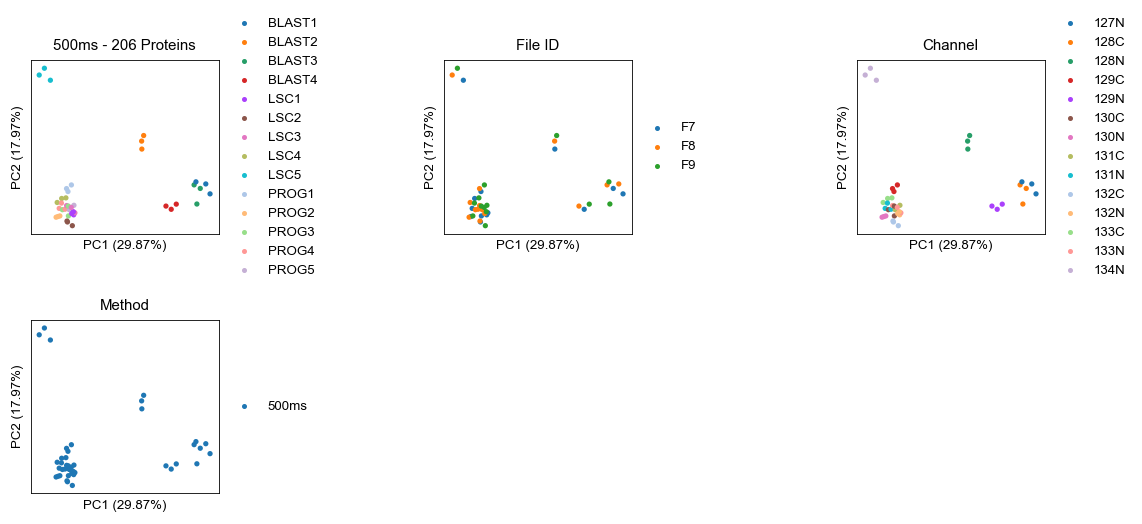

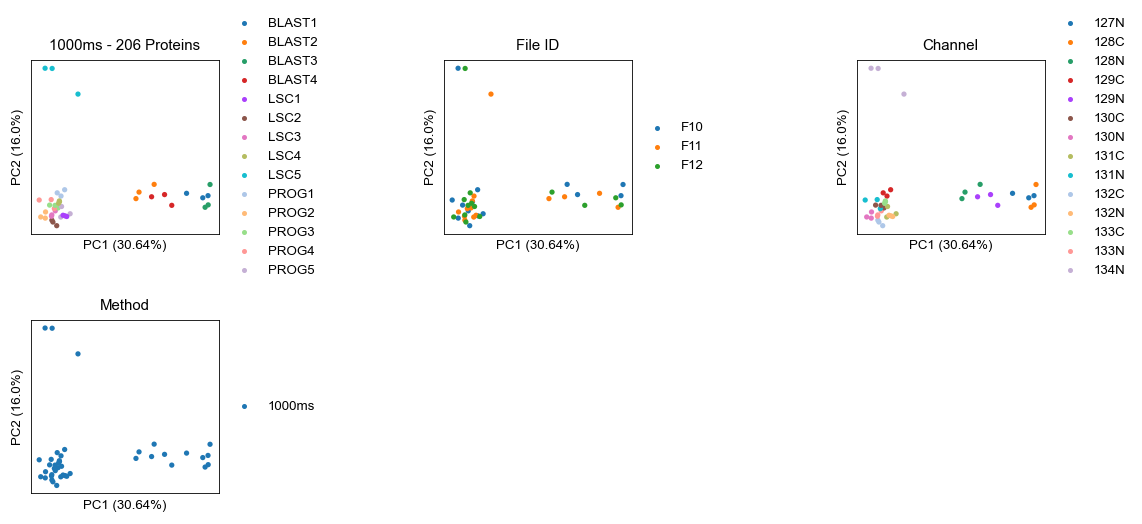

In [59]:
# plot pca of each cell pool but only overlapping proteins
overlap = adata

for j in adata.obs['Method'].unique():
    adata_slice = adata[adata.obs['Method']==j].copy()
    sc.pp.normalize_total(adata_slice, exclude_highly_expressed=True) # median shift of total intensity across cells
    sc.pp.log1p(adata_slice, base=2) # log2(x+1) transformation
    adata_slice = adata_slice[:, sc.pp.filter_genes(adata, min_cells=adata.shape[0], inplace=False)[0]].copy()
    sc.pp.pca(adata_slice, n_comps=20)
    axs = sc.pl.pca(adata_slice, color=['Cell Pool', 'File ID', 'Channel', 'Method',], size=cellsize, wspace=wspace, hspace=hspace,
                    ncols=3, show=False, title='{} - {} Proteins'.format(j, adata_slice.shape[1]), annotate_var_explained=True)
    # blast vs lsc sihuette score
    adata_slice = adata_slice[adata_slice.obs['Celltype'].isin(['BLAST', 'LSC'])]
    silhouettes['overlap'][j] = silhouette_samples(adata_slice.obsm['X_pca'], adata_slice.obs['Celltype'])
    plt.savefig(res_dir + 'pca_overlap_{}.pdf'.format(j), transparent=True)

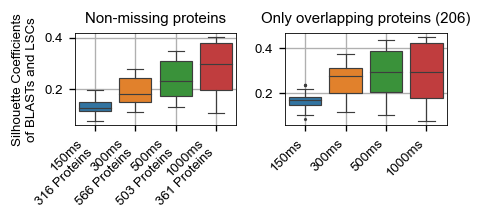

In [60]:
# plot blast vs. lsc silhoutte coefficients
fig, ax = plt.subplots(1, 2, figsize=(4, 1), gridspec_kw={'wspace':0.3})
specific = pd.DataFrame(silhouettes['specific']).melt(value_name='Silhouette Coefficient')
overlap = pd.DataFrame(silhouettes['overlap']).melt(value_name='Silhouette Coefficient')
sns.boxplot(data=specific, x='variable', y='Silhouette Coefficient', ax=ax[0], fliersize=1)
sns.boxplot(data=overlap, x='variable', y='Silhouette Coefficient', ax=ax[1], fliersize=1)
ls = [item.get_text() for item in ax[0].get_xticklabels()]
ls = ['{}\n{} Proteins'.format(s, num_prots[s]) for s in ls]
ax[0].set_xticklabels(ls, rotation=45, ha='right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[0].axes.get_xaxis().get_label().set_visible(False)
ax[1].axes.get_xaxis().get_label().set_visible(False)
ax[1].axes.get_yaxis().get_label().set_visible(False)
ax[0].set_ylabel('Silhouette Coefficients\nof BLASTs and LSCs')
ax[0].set_title('Non-missing proteins') 
ax[1].set_title('Only overlapping proteins ({})'.format(adata_slice.shape[1])) 
ax[0].grid()
ax[1].grid()
plt.savefig(res_dir + 'silhouettes.pdf', bbox_inches='tight', transparent=True)

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

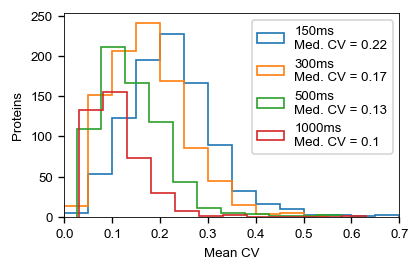

In [61]:
# plot histogram mean cv
df = CVs[num ==3].reset_index().drop('Cell Pool', axis=1).groupby('Method').mean().stack().reset_index()

binwidth = 0.05
fig, ax = plt.subplots(figsize=(figwd*0.50, 2.2))
sns.distplot(df[df['Method'] == '150ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step", "alpha": 1}, label='150ms\nMed. CV = {}'.format(round(df[df['Method'] == '150ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '150ms'][0]), max(df[df['Method'] == '150ms'][0]) + binwidth, binwidth), ax=ax)
sns.distplot(df[df['Method'] == '300ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step","alpha": 1}, label='300ms\nMed. CV = {}'.format(round(df[df['Method'] == '300ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '300ms'][0]), max(df[df['Method'] == '300ms'][0]) + binwidth, binwidth), ax=ax)
sns.distplot(df[df['Method'] == '500ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step", "alpha": 1}, label='500ms\nMed. CV = {}'.format(round(df[df['Method'] == '500ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '500ms'][0]), max(df[df['Method'] == '500ms'][0]) + binwidth, binwidth), ax=ax)
sns.distplot(df[df['Method'] == '1000ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step", "alpha": 1}, label='1000ms\nMed. CV = {}'.format(round(df[df['Method'] == '1000ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '1000ms'][0]), max(df[df['Method'] == '1000ms'][0]) + binwidth, binwidth), ax=ax)

plt.xlabel('Mean CV')
plt.ylabel('Proteins')
plt.xlim(0, 0.7)
plt.legend()
plt.savefig(res_dir + 'cv_dist.pdf', bbox_inches='tight', transparent=True)

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

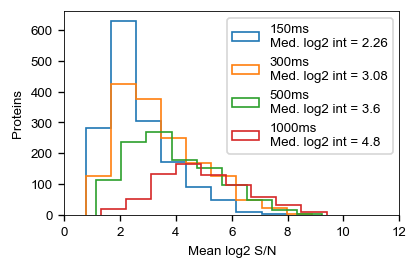

In [62]:
# plot histogram mean log2 sn
df = means.reset_index().drop('Cell Pool', axis=1).groupby('Method').mean().stack().apply(np.log2).reset_index()

binwidth = 0.9
fig, ax = plt.subplots(figsize=(figwd*0.50, 2.2))
sns.distplot(df[df['Method'] == '150ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step", "alpha": 1}, label='150ms\nMed. log2 int = {}'.format(round(df[df['Method'] == '150ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '150ms'][0]), max(df[df['Method'] == '150ms'][0]) + binwidth, binwidth), ax=ax)
sns.distplot(df[df['Method'] == '300ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step","alpha": 1}, label='300ms\nMed. log2 int = {}'.format(round(df[df['Method'] == '300ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '300ms'][0]), max(df[df['Method'] == '300ms'][0]) + binwidth, binwidth), ax=ax)
sns.distplot(df[df['Method'] == '500ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step", "alpha": 1}, label='500ms\nMed. log2 int = {}'.format(round(df[df['Method'] == '500ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '500ms'][0]), max(df[df['Method'] == '500ms'][0]) + binwidth, binwidth), ax=ax)
sns.distplot(df[df['Method'] == '1000ms'][0], kde=False, norm_hist=False,
             hist_kws={"histtype": "step", "alpha": 1}, label='1000ms\nMed. log2 int = {}'.format(round(df[df['Method'] == '1000ms'][0].median(), 2)),
             bins=np.arange(min(df[df['Method'] == '1000ms'][0]), max(df[df['Method'] == '1000ms'][0]) + binwidth, binwidth), ax=ax)

plt.xlabel('Mean log2 S/N')
plt.ylabel('Proteins')
plt.xlim(0, 12)
plt.legend()
plt.savefig(res_dir + 'SN_dist.pdf', bbox_inches='tight', transparent=True)

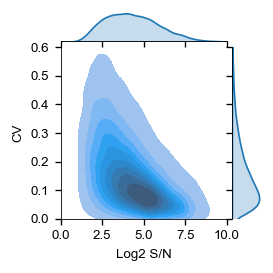

In [63]:
sns.jointplot(x = means[num == 3].stack().apply(np.log2), y = CVs[num == 3].stack(), kind="kde", fill=True,
              xlim=(0, 10), ylim=(0, 0.6), height=figwd*0.3).set_axis_labels('Log2 S/N', 'CV')
plt.savefig(res_dir + 'cv_sn.pdf', bbox_inches='tight', format='pdf')

In [64]:
# compare fold changes to library for BLAST and LSC
# all non-missing proteins
log2foldchanges = {}
prots = pd.DataFrame(index=adata.var.index)
for m in adata.obs['Method'].unique():
    means = {}
    adata_slice = adata[(adata.obs['Method']==m)].copy()
    sc.pp.normalize_total(adata_slice, exclude_highly_expressed=True) # median shift of total intensity across cells
    sc.pp.filter_genes(adata_slice, min_cells=adata_slice.shape[0])
    sc.pp.log1p(adata_slice, base=2) # log2(x+1) transformation
    for c in ['BLAST', 'LSC', 'PROG']:
        ar = adata_slice[(adata_slice.obs['Cell Pool'].str.contains(c)), :].X
        slice_prots = adata_slice[(adata_slice.obs['Cell Pool'].str.contains(c)), :].var.index
        means[c] = np.nanmean(np.where(ar==0, np.nan, ar), axis=0)
    log2foldchanges[m] = means['LSC'] - means['BLAST']
    prots = prots.merge(pd.Series(log2foldchanges[m], index=slice_prots, name=m), left_index=True, right_index=True, how='left')

ms3_lib = pd.read_table('../data/library/library_MS3_Proteins.txt')
comp = prots.merge(ms3_lib[['Accession',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
    'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
    'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
}), left_index=True, right_on='Accession')

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1496 genes that are detected in less than 42 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1246 genes that are detected in less than 42 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
filtered out 1309 genes that are detected in less than 42 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Q58F21']
    finished (0:00:00)
filtered out 1451 genes that are detected in less than 42 cells


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [65]:
# only overlap
prots = adata.var[(adata.X > 0).all(axis=0)].index
log2foldchanges = {}
for m in adata.obs['Method'].unique():
    means = {}
    adata_slice = adata[(adata.obs['Method']==m)].copy()
    sc.pp.normalize_total(adata_slice, exclude_highly_expressed=True) # median shift of total intensity across cells
    sc.pp.log1p(adata_slice, base=2) # log2(x+1) transformation
    for c in ['BLAST', 'LSC', 'PROG']:
        ar = adata_slice[(adata_slice.obs['Cell Pool'].str.contains(c)), prots].X
        means[c] = np.nanmean(np.where(ar==0, np.nan, ar), axis=0)
    log2foldchanges[m] = means['LSC'] - means['BLAST']

df = pd.DataFrame(log2foldchanges)
df.index = prots

comp_overlap = df.merge(ms3_lib[['Accession',
                         'Abundance Ratio log2 LSC  BLAST',
                         'Abundance Ratio Adj P-Value LSC  BLAST']].rename(columns={
    'Abundance Ratio log2 LSC  BLAST':'log2foldchange_lib',
    'Abundance Ratio Adj P-Value LSC  BLAST': 'pval_adj_lib'
}), left_index=True, right_on='Accession')

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Q58F21']
    finished (0:00:00)


/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


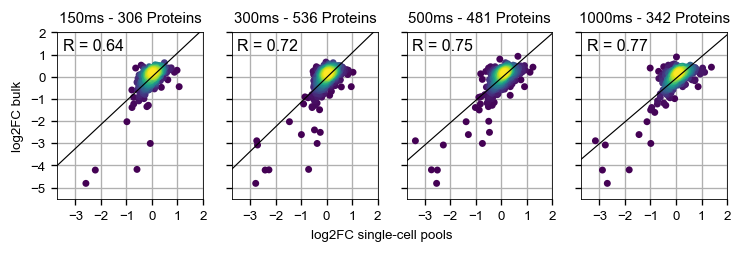

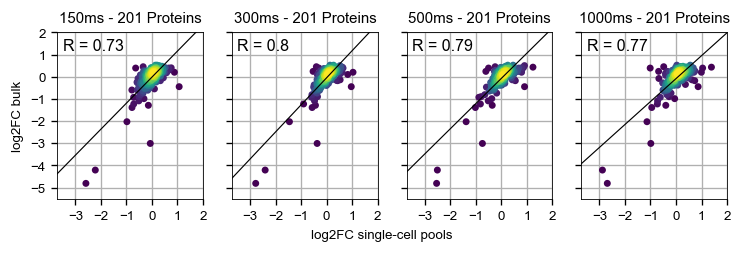

In [66]:
from scipy.stats import gaussian_kde
from scipy.stats import linregress

r_vals = {'comp':{}, 'comp_overlap':{}}
num_prots = {'comp':{}, 'comp_overlap':{}}
for j, c in enumerate([comp, comp_overlap]):

    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(7.2, 1.8))
    axs = axs.flatten()
    for i, m in enumerate(['150ms', '300ms', '500ms', '1000ms']):

        x = c[[m, 'log2foldchange_lib']].dropna()[m].values
        y = c[[m, 'log2foldchange_lib']].dropna()['log2foldchange_lib'].values
        reg = linregress(x,y)
        r_vals[['comp', 'comp_overlap'][j]][m] = reg.rvalue
        num_prots[['comp', 'comp_overlap'][j]][m] = len(x)

        # Calculate the point density
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

        ax = axs[i]
        ax.scatter(x, y, c=z, s=10)
        ax.plot(range(-4, 4), reg.slope*range(-4, 4) + reg.intercept, c='black')
        ax.text(-3.5, 1.2, 'R = {}'.format(round(reg.rvalue, 2)), size='large')
        ax.set_xticks(range(-5, 5))
        ax.set_yticks(range(-5, 5))
        ax.set_xlim((-3.7, 2))
        ax.set_ylim((-5.5, 2))
        ax.set_title('{} - {} Proteins'.format(m, len(x)))
        ax.set_xlabel(' ')
        if i == 0:
            ax.set_ylabel('log2FC bulk')
        ax.grid()
    fig.text(0.5, -0.03, 'log2FC single-cell pools', ha='center', va='top', size=plt.rcParams['axes.labelsize'])
    fig.savefig(res_dir + 'fold_changes_{}.pdf'.format(['non_missing', 'overlap'][j]), bbox_inches='tight', transparent=True)

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


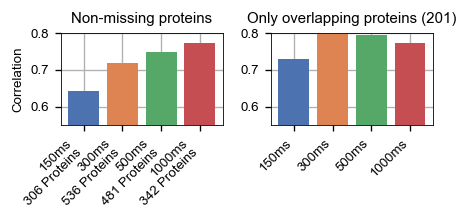

In [109]:
# correlation as barplots
fig, ax = plt.subplots(1, 2, figsize=(4, 1), gridspec_kw={'wspace':0.3})
df = pd.DataFrame(r_vals)
df = df.rename({'comp_overlap': 'Only overlapping proteins ({})'.format(list(num_prots['comp_overlap'].values())[0]), 'comp': 'Non-missing proteins'}, axis=1)
#df.plot.bar(ax=ax, subplots=True, legend=False, grid=True)
ax[0].bar(df.index, df["Non-missing proteins"], color=sns.color_palette('deep')[:4])
ax[1].bar(df.index, df["Only overlapping proteins (201)"], color=sns.color_palette('deep')[:4])
ax[0].set_title("Non-missing proteins")
ax[1].set_title("Only overlapping proteins (201)")
ls = df.index
ls = ['{}\n{} Proteins'.format(s, num_prots['comp'][s]) for s in ls]
ax[0].set_xticklabels(ls, rotation=45, ha='right')
ax[1].set_xticklabels(df.index, rotation=45, ha='right')
ax[0].set_ylabel('Correlation')
ax[0].set_ylim((0.55, 0.8))
ax[1].set_ylim((0.55, 0.8))
ax[0].grid()
ax[1].grid()
fig.savefig(res_dir + 'correlations.pdf', bbox_inches='tight', transparent=True)

In [ ]:
os.system('jupyter nbconvert --to html cv_analysis.ipynb --output-dir={}'.format(res_dir))